In [32]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright


# Time Evolution - Ising Hamiltonian with OBC

 ### $ H =  \sum_{i=0}^{N-2} Z_i Z_{i+1} + h \sum_{i=0}^{N-1} X_i $
 
 ### Goals:


- Preparing the initial state $|0010 \rangle$ ;
- Complete the function that implements the Trotter evolution of the Ising model ;
- Run the quantum circuit and compute the time evolution ;
- Visualize the expectation value of the total magnetization  $M = \langle \sum_i Z_i \rangle$  spin correlations and site resolved expectation  $\langle Z_i \rangle$  as a function of time and compare to the exact solution ;
- Apply error mitigation techniques and show the performance .


In [33]:
import numpy as np
from numpy import linalg
from scipy import linalg
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp


from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

from scipy.linalg import expm
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Kraus, SuperOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.quantum_info import Statevector

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.opflow import Z, I, X, Zero, One
from qiskit.circuit.library import EfficientSU2

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit import IBMQ, Aer
from qiskit_aer.noise import NoiseModel

from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

from numpy import pi, array,sqrt,exp,savetxt,loadtxt

from qiskit.providers.fake_provider import FakeManila

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex
from qiskit import QuantumRegister

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import phase_amplitude_damping_error

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn

import qiskit
from qiskit               import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute, Aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow              import PauliSumOp
from qiskit.quantum_info        import SparsePauliOp

import math
import numpy as np
from numpy import linalg

from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise


from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.opflow import I, X, Y, Z, One, Zero

from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex
from qiskit import QuantumRegister

from qiskit import IBMQ

In [34]:
# Define the Hamiltonian of the Ising model
def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    # Return the matrix representation of the Ising model
    return hamiltonian

In [35]:
#print('N=2: \n', H_ising(2,1,4), '\nN=4: \n',H_ising(4,1,4))

In [36]:
def U_ising(num_qubits,J,b,t):
    # Compute Ising Hamiltonian for fixed parameters   
    H = H_ising(num_qubits,J,b)
    
    # Return the exponential of -i multipled by time t multipled by the Ising Hamiltonian 
    return (t * H).exp_i()

# Classical simulation of  the Ising model

Now that we have the time evolution operator we can apply it to the initial state and study its time dependent properties.
We consider a system of $ N = 4 $ spins with the initial state $| \psi_0 \rangle = |0010\rangle$ and evolve it up until total time $T = \pi$. $\newline$
We will measure the overlap with the initial state at every time $t$: $O(t) = |\langle 0010|U(t)|0010\rangle|^2 $

In [37]:
# Define array of time points: 100 points in  [0,\pi]
ts = np.linspace(0, np.pi, 100)

num_qubits=4 # Define the number of qubits

# Define Ising Hamiltonian parameters
J=-1
b=4

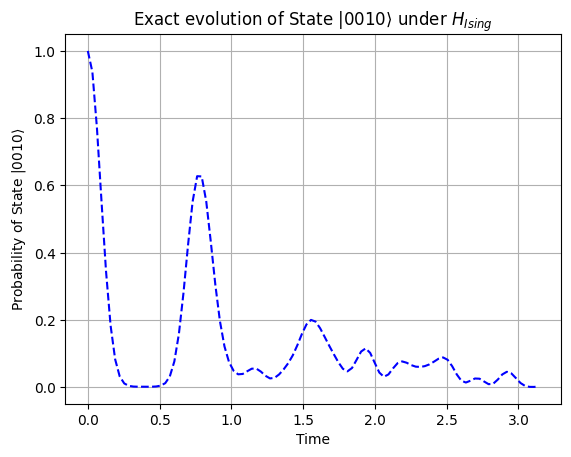

In [38]:
# Define initial state |0010> 
initial_state = Zero^One^Zero^Zero

# Compute probability of remaining in |0010> state over the array of time points
 # ~initial_state gives the bra of the initial state (<0010|)
 # @ is short hand for matrix multiplication
 # U_ising(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <0010|U_ising(t)|0010>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value,
 # or probability, of remaining in |0010>
probs_0010_exact = [np.abs((~initial_state @ U_ising(num_qubits,J,b,float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |0010>
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="blue")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Exact evolution of State $|0010\rangle$ under $H_{Ising}$')
plt.grid()
plt.show()

# Quantum simulation of  the Ising model
- ### $N = 2$ :

$$ H_{ising2} = Z_0 Z_1 + h ( X_0 + X_1 ) $$ $\newline$
$$U_{ising2}(t) = e^{-it H_{ising2} }$$ 

Here $Z_0Z_1$ and $X_i$ commute, this means that the exponential decomposition using Trotterization of a 2 spins Hamiltonian is exact, than:

$$U_{ising2}(t) = e^{-it Z_0Z_1} \cdot  e^{-it h X_0} \cdot e^{-it h X_1}$$

Qiskit already includes these operations, but we can construct these operations using only  universal set of operations containing single qubit rotations and the $\mathrm{CNOT}$ gate, since this is what is natively implemented on the IBMQ devices.
The simplest transformation to implement is  $\mathrm{ZZ}(\delta)$:
$$
\mathrm{ZZ}(\delta) = e^{-i\delta Z_0Z_1}
$$
It corresponds to a combination of two $\mathrm{CNOT}$ gates and a single phase gate 
$$
\mathrm{ZZ}(\delta) \rightarrow \mathrm{CNOT}(q_c,q_t) \left(\mathcal{I}_{q_c}\otimes\mathrm{U}(-2\delta)_{q_t}\right) \mathrm{CNOT}(q_c,q_t)
$$

- ### $N = 4$ : 

The exponential $U_{ising4}(t)$ cannot be split into a product of simpler exponentials.
However, we can approximate $U_{ising4}(t)$ as a product of simpler exponentials through Trotterization. 
Consider again the 2 spin case, within the larger 4 spin system. 

Rewritting $U_{ising4}(t)$ in terms of the three possible subsystems within the total $N=4$ system you will simulate,

$$
U_{ising4}(t) = \exp\left[-i t \left(H^{(0,1)}_{ising2} + H^{(1,2)}_{ising2} + H^{(2,3)}_{ising2} \right)\right].
$$

$H^{(0,1)}_{ising2}$, $H^{(1,2)}_{ising2}$ and $H^{(2,3)}_{ising2}$  do not commute, so $U_{ising4}(t) \neq \exp\left(-i t H^{(0,1)}_{ising2}\right) \exp\left(-i t H^{(1,2)}_{ising3} \right) \exp\left(-i t H^{(2,3)}_{ising2}\right)$.


But, this product decomposition can be approximated with Trotterization which says $U_{ising4}(t)$ is approximately a short evolution of $H^{(0,1)}_{ising2}$ (time = $\frac{t}{n}$) and followed by a short evolution of $H^{(1,2)}_{ising2}$ (time = $\frac{t}{n}$) and of $H^{(2,3)}_{ising2}$ (time = $\frac{t}{n}$)  repeated $n$ times.

$$
\begin{align}
U_{ising4}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{ising2}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{ising2} \right) \exp\left(\dfrac{-it}{n}H^{(2,3)}_{ising2}\right) \right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate.

In [39]:
# Here we introduce a general function for the Ising model Trotter evolution
# The circuit will not contain the initialisation

def Ising_Trotter(num_qubits, J, b, trotter_steps, t):
    
    ''' 
    Args:
        - num_spins: int, number of qubits of the system
        - trotter_steps: the number of trotter steps n to implement
        - t: the simulation time we are targeting
        
    Returns:
        A QuantumCircuit implementing the Trotterization of the time evolutiom operator for the Ising
        model
    '''
    
    # Dato il tempo di evoluzione totale e il numero di Trotter steps, 
    # per ogni step il circuito evolverà di dt = tempo_totale / trotter_steps
    dt = t/trotter_steps

    # Inizializziamo il circuito iniziale con il numero di qubits scelto
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr) 
    
    #Per ogni Trotter step faccio evolvere lo stato ( quindi tutti i qubit ) dell'intervallo di tempo dt
    for _ in range(trotter_steps):
        for i in range(0, num_qubits):
            qc.rx(b*2*dt,i)

        for i in range(0, num_qubits - 1):
            qc.rzz(J*2*dt,i,i+1)
            
        # To separate the different Trotter steps
        qc.barrier()


    return qc

In [40]:
# Examplpe of Trotter decomposition
#Ising_Trotter(num_qubits,J,b,10,1).draw('mpl')

In [43]:
token = '131dafb33fa9e0aaf19cb464af0f54b689c1cc2350962f573a7a50e2e0fac7455c002ba31b1d450f270a0d9c258fa12d03d2814a7405d1087ae8363a694f9283'
#provider = IBMQ.enable_account(token)

In [44]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [45]:
#Select Hardware 

HW='ibmq_manila'

## Noisless

In [46]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8, 12, 15 Trotter steps

backend = Aer.get_backend("qasm_simulator")
probs_0010_trott = {4:[], 8:[], 12:[], 15:[]}

expectation = PauliExpectation() 
sampler     = CircuitSampler(backend)

# Create the observable
# We want to measure |0010><0010|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

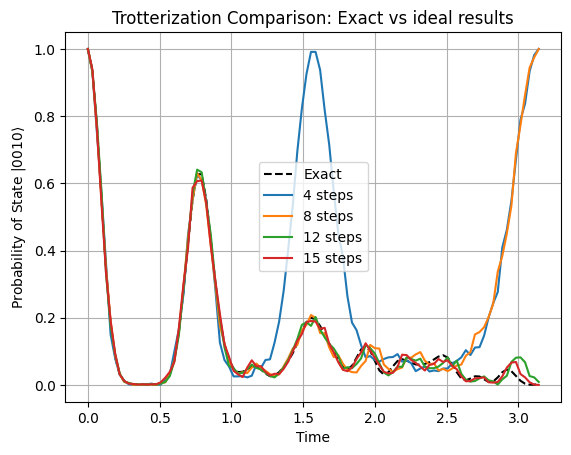

In [47]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_0010_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Trotterization Comparison: Exact vs ideal results')
plt.legend()
plt.grid()
plt.show()

## Hardware noise model

In [48]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8, 12, 15 Trotter steps

device = provider.get_backend(HW)
coupling_map = device.configuration().coupling_map
prop = device.properties()
noise_model = NoiseModel.from_backend(device)  #Noise model from backend
backend = Aer.get_backend('qasm_simulator')
basis_gates = noise_model.basis_gates
quantum_instance = QuantumInstance(backend,
                                       shots=8000,
                                       basis_gates=basis_gates,
                                       noise_model=noise_model,
                                       coupling_map=coupling_map)
probs_0010_trott = {4:[], 8:[], 12:[], 15:[]}

expectation = PauliExpectation() 
sampler     = CircuitSampler(quantum_instance)

# Create the observable
# We want to measure |0010><0010|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

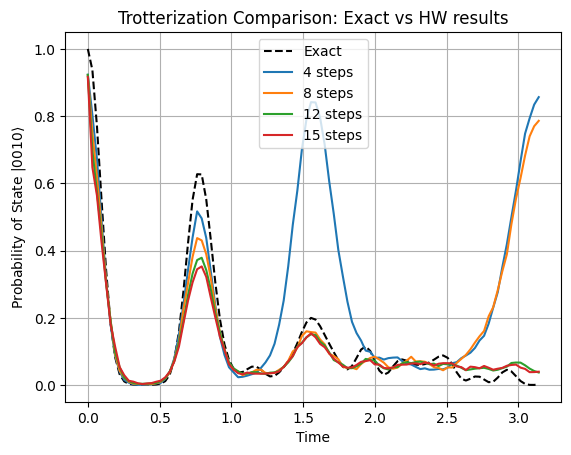

In [49]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_0010_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Trotterization Comparison: Exact vs HW results')
plt.legend()
plt.grid()
plt.show()

As we can see from the plot , the dynamics gets closer and closer to the exact state evolution as we increase the number of Trotter steps.

## Custom noise model

In [50]:
def noise_model(backend,qubits_layout):
    
    p_reset = 0.03
    p_meas = 0.01
    p_gate1 = 0.05
    
    
    tg = 35 * 10**(-9)
    
    nqubit = len(qubits_layout)
    
    noise_model = NoiseModel()
    
    prop = backend.properties()
    
    t_cnot = np.zeros((nqubit,nqubit))
        
    p_cnot = np.zeros((nqubit,nqubit))
    
    #Read from backend

    T1 = [prop.t1(j) for j in qubits_layout] #relaxation time
    T2 = [prop.t2(j) for j in qubits_layout]  #T2
    p = [prop.gate_error('x',[j]) for j in qubits_layout] #x dep error for each qubit
    rout = [prop.readout_error(j) for j in qubits_layout] #readout error for each qubit

    if (nqubit > 1):
        for i in range(0,nqubit):
            if (i == 0):
                t_cnot[0][1] = prop.gate_length('cx',[qubits_layout[0],qubits_layout[1]]) #Gate length for cnot
                p_cnot[0][1] = prop.gate_error('cx',[qubits_layout[0],qubits_layout[1]]) #Gate dep error for cnot
            if (i != 0 and i != nqubit-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                t_cnot[i][i+1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i+1]])
                p_cnot[i][i+1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i+1]])
            if (i == nqubit-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
    
   
        
    for j in range(0,nqubit):
        
        #single qubit depolarizing
        
        dep = depolarizing_error(p[j],1)# input: prob, num_qubit
        
        #single qubit relaxation
        
        Tph = T1[j] * T2[j] / (2 * T1[j] - T2[j]) 
        p1 = 1 - exp(-tg/T1[j]) #probability of dephasing in time tg
        p_ph = 1 - exp(-tg/Tph) 
        pz = (1 - p1) * p_ph 
          
        relax = phase_amplitude_damping_error(p1,pz)
        
        #spam
          
        spam = pauli_error([('X',rout[j]), ('I', 1 - rout[j])]) #readout error 
        
        #adding errors to noise model
        
        single_qubit_gate_error = dep.compose(relax)
        
        noise_model.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        
        noise_model.add_quantum_error(spam, "measure",[qubits_layout[j]])
        

        
    for j in range(0,nqubit):
        for k in range(0,nqubit):
            if (k == j+1 or k == j-1):
                
                #two qubits relaxation
            
                Tph_j = T1[j] * T2[j] / (2 * T1[j] - T2[j])
                p1_j = 1 - exp(-t_cnot[j][k]/T1[j]) #prob damping
                p_ph_j = 1 - exp(-t_cnot[j][k]/Tph_j) #prob dephasing
                pz_j = (1 - p1_j) * p_ph_j #prob damping and dephasing
                
                Tph_k = T1[k] * T2[k] / (2 * T1[k] - T2[k])
                p1_k = 1 - exp(-t_cnot[j][k]/T1[k])
                p_ph_k = 1 - exp(-t_cnot[j][k]/Tph_k)
                pz_k = (1 - p1_k) * p_ph_k
        
                relax_j = phase_amplitude_damping_error(p1_j,pz_j)
                relax_k = phase_amplitude_damping_error(p1_k,pz_k)
                relax_jk = relax_k.tensor(relax_j)
   
                
                #two qubits depolarizing
                
                dep_j = depolarizing_error(p_cnot[j][k],1)
                dep_k = depolarizing_error(p_cnot[j][k],1)
                dep_cnot = dep_k.tensor(dep_j) 
                
                #adding errors to noise model
                
                two_qubits_gate_error = dep_cnot.compose(relax_jk)
                
                noise_model.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
                
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
    error=thermal_relaxation_error(T1[qubits_layout[0]],T2[qubits_layout[0]], tg)#thermal relaxation error for qubit 0
    
    #noise_model.add_nonlocal_quantum_error(error_reset, "reset", qubits_layout[0],qubits_layout[nqubit-1])# reset error 
    #noise_model.add_quantum_error(error, ['x','id'], qubits_layout[0])
    noise_model.add_quantum_error(error_gate2, "cx", [qubits_layout[0],qubits_layout[nqubit-1]])

    
    return noise_model

In [51]:
#We build quantum instance based on our custom noise

device = provider.get_backend(HW)
coupling_map = device.configuration().coupling_map
prop = device.properties()
noise_model_custom = noise_model( device, [i for i in range(num_qubits)] )
backend = Aer.get_backend('qasm_simulator')
basis_gates = noise_model_custom.basis_gates
quantum_instance = QuantumInstance(backend,
                                       shots=8000,
                                       basis_gates=basis_gates,
                                       noise_model=noise_model_custom,
                                       coupling_map=coupling_map)

In [52]:
print(noise_model_custom)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'measure', 'x', 'sx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (0, 3))]


In [53]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8, 12, 15 Trotter steps

probs_0010_trott = {4:[], 8:[], 12:[], 15:[]}

expectation = PauliExpectation() 
sampler     = CircuitSampler(quantum_instance)

# Create the observable
# We want to measure |0010><0010|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

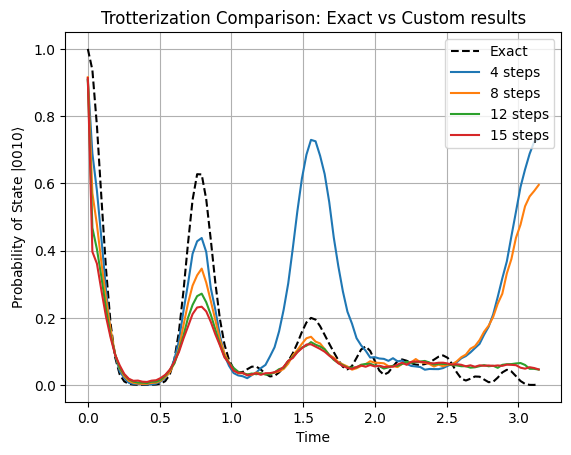

In [54]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_0010_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Trotterization Comparison: Exact vs Custom results')
plt.legend()
plt.grid()
plt.show()

## Hardware mitigated results

In [55]:

backend = Aer.get_backend('qasm_simulator')
device = provider.get_backend(HW)
noise_model=NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map
quantum_instance = QuantumInstance(backend,
                                       shots=8000,
                                       basis_gates=basis_gates,
                                       coupling_map=coupling_map,
                                       noise_model=noise_model,
                                       measurement_error_mitigation_cls=CompleteMeasFitter)#Complete measurement fitter

In [56]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex

qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

sim = Aer.get_backend('qasm_simulator',noise_model=noise_model)

t_qc = transpile(meas_calibs,sim)

qobj = assemble(t_qc, shots=10000)
cal_results = sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print("Conversion Matrix")
array_to_latex(meas_fitter.cal_matrix)

Conversion Matrix


<IPython.core.display.Latex object>

In [57]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8, 12, 15 Trotter steps

probs_0010_trott = {4:[], 8:[], 12:[], 15:[]}

expectation = PauliExpectation() 
sampler     = CircuitSampler(quantum_instance)

# Create the observable
# We want to measure |0010><0010|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

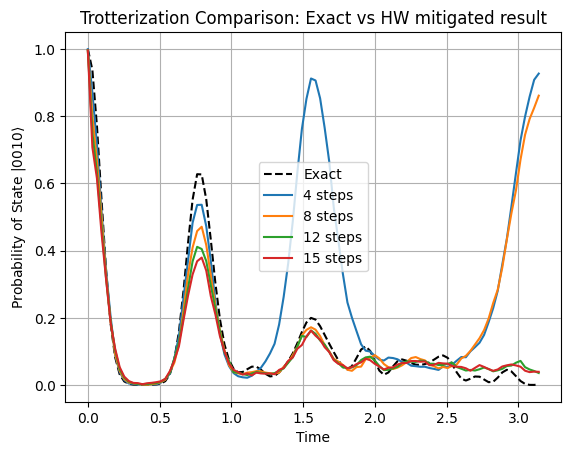

In [58]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_0010_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Trotterization Comparison: Exact vs HW mitigated result')
plt.legend()
plt.grid()
plt.show()

## Custom noise mitigated results

In [59]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex

qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

custom_sim = Aer.get_backend('qasm_simulator',noise_model=noise_model_custom)

t_qc = transpile(meas_calibs,custom_sim)

qobj = assemble(t_qc, shots=10000)
cal_results = custom_sim.run(qobj, noise_model=noise_model_custom, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print("Conversion Matrix Custom")
array_to_latex(meas_fitter.cal_matrix)

Conversion Matrix Custom


<IPython.core.display.Latex object>

In [60]:

backend = Aer.get_backend('qasm_simulator')
device = provider.get_backend(HW)
noise_model = noise_model_custom
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map
quantum_instance = QuantumInstance(backend,
                                       shots=8000,
                                       basis_gates=basis_gates,
                                       coupling_map=coupling_map,
                                       noise_model=noise_model,
                                       measurement_error_mitigation_cls=CompleteMeasFitter)#Complete measurement fitter

In [61]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8, 12, 15 Trotter steps

probs_0010_trott = {4:[], 8:[], 12:[], 15:[]}

expectation = PauliExpectation() 
sampler     = CircuitSampler(quantum_instance)

# Create the observable
# We want to measure |0010><0010|
prj = StateFn((1/16)*(I+Z)^(I-Z)^(I+Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_0010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(4)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(2)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_0010_trott[n].append(trott_sample.eval().real)

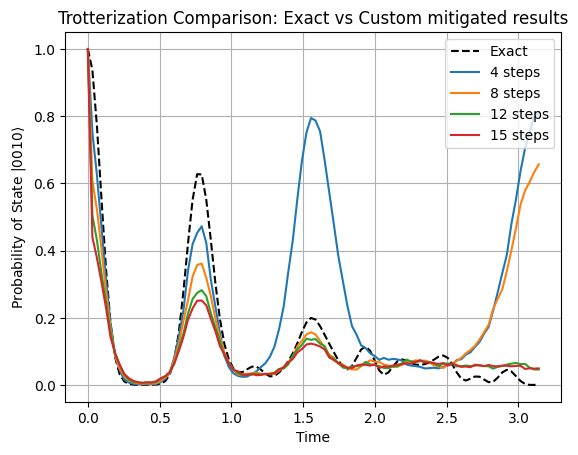

In [62]:
# Now plot the comparison
plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_0010_trott.keys()):
    plt.plot(ts, probs_0010_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|0010\rangle$')
plt.title(r'Trotterization Comparison: Exact vs Custom mitigated results')
plt.legend()
plt.grid()
plt.show()

# Other parameters:  

## $ N_{qubits}  = 3 $

In [63]:
# Define array of time points: 100 points in  [0,\pi]
ts = np.linspace(0, np.pi, 100)

num_qubits = 3 # Define the number of qubits

# Define Ising Hamiltonian parameters
J=-1
b=np.array(np.linspace(1,4,3))

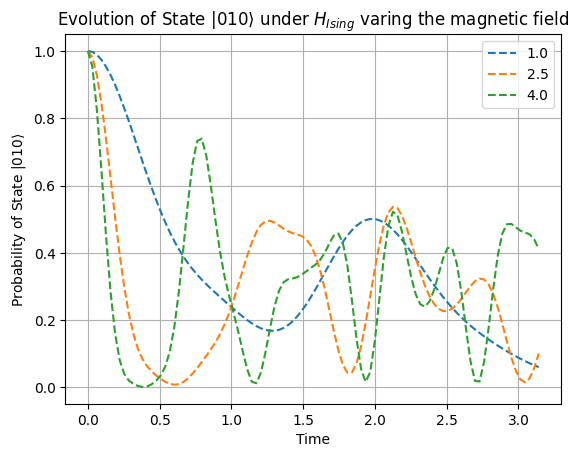

In [64]:
# Define initial state |010> 
initial_state = Zero^One^Zero

for i in b:
    # Compute probability of remaining in |0010> state over the array of time points
     # ~initial_state gives the bra of the initial state (<0010|)
     # @ is short hand for matrix multiplication
     # U_ising(t) is the unitary time evolution at time t
     # t needs to be wrapped with float(t) to avoid a bug
     # (...).eval() returns the inner product <0010|U_ising(t)|0010>
     #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value,
     # or probability, of remaining in |0010>
    probs_010_exact = [np.abs((~initial_state @ U_ising(num_qubits,J,i,float(t)) @ initial_state).eval())**2 for t in ts]

    # Plot evolution of |010>
    plt.plot(ts, probs_010_exact,linestyle="dashed",label=i)
    plt.xlabel('Time')
    plt.ylabel(r'Probability of State $|010\rangle$')
    plt.title(r'Evolution of State $|010\rangle$ under $H_{Ising}$ varing the magnetic field')
    plt.legend()
    plt.grid()
    
    
plt.show()

## Comparison between harware results at different values of h and fixed Trotter steps

### Noisy results

In [65]:
#Quantum instance based on the hardware model
device = provider.get_backend(HW)
coupling_map = device.configuration().coupling_map
prop = device.properties()
noise_model = NoiseModel.from_backend(device)  #Noise model from backend
backend = Aer.get_backend('qasm_simulator')
basis_gates = noise_model.basis_gates
quantum_instance = QuantumInstance(backend,
                                       shots=8000,
                                       basis_gates=basis_gates,
                                       noise_model=noise_model,
                                       coupling_map=coupling_map)

In [66]:
probs_010_trott = {i:[] for i in b}

expectation = PauliExpectation() 
sampler     = CircuitSampler(quantum_instance)
N=15
# Create the observable
# We want to measure |010><010|
prj = StateFn((1/8)*(I+Z)^(I-Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(1)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=3,J=-1,b=n,trotter_steps=N,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_010_trott[n].append(trott_sample.eval().real)

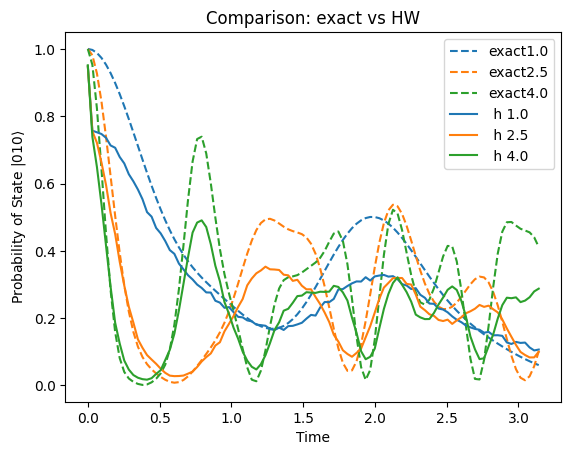

In [67]:
# Now plot the comparison
#plt.plot(ts, probs_010_exact,linestyle="dashed",color="black",label="Exact")
initial_state = Zero^One^Zero

for i in b:
    # Compute probability of remaining in |0010> state over the array of time points
     # ~initial_state gives the bra of the initial state (<0010|)
     # @ is short hand for matrix multiplication
     # U_ising(t) is the unitary time evolution at time t
     # t needs to be wrapped with float(t) to avoid a bug
     # (...).eval() returns the inner product <0010|U_ising(t)|0010>
     #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value,
     # or probability, of remaining in |0010>
    probs_010_exact = [np.abs((~initial_state @ U_ising(num_qubits,J,i,float(t)) @ initial_state).eval())**2 for t in ts]

    # Plot evolution of |010>
    plt.plot(ts, probs_010_exact,linestyle="dashed",label="exact" + str(i))
    plt.xlabel('Time')
    plt.ylabel(r'Probability of State $|010\rangle$')
    plt.title(r'Evolution of State $|010\rangle$ under $H_{Ising}$ varing the magnetic field')
    plt.legend()
    plt.grid()
    
for (i,n) in enumerate(probs_010_trott.keys()):
    plt.plot(ts, probs_010_trott[n],color="C"+str(i),label=" h "+ str(n))
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|010\rangle$')
plt.title(r'Comparison: exact vs HW')
plt.legend()
plt.grid()


plt.show()

### Mitigated results

In [68]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex

qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

sim = Aer.get_backend('qasm_simulator',noise_model=noise_model)

t_qc = transpile(meas_calibs,sim)

qobj = assemble(t_qc, shots=10000)
cal_results = sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print("Conversion Matrix")
array_to_latex(meas_fitter.cal_matrix)

Conversion Matrix


<IPython.core.display.Latex object>

In [69]:
backend = Aer.get_backend('qasm_simulator')
device = provider.get_backend(HW)
noise_model=NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map
quantum_instance = QuantumInstance(backend,
                                       shots=8000,
                                       basis_gates=basis_gates,
                                       coupling_map=coupling_map,
                                       noise_model=noise_model,
                                       measurement_error_mitigation_cls=CompleteMeasFitter)#Complete measurement fitter

In [70]:
probs_010_trott_mitigated = {i:[] for i in b}

expectation = PauliExpectation() 
sampler     = CircuitSampler(quantum_instance)
N=15
# Create the observable
# We want to measure |010><010|
prj = StateFn((1/8)*(I+Z)^(I-Z)^(I+Z),is_measurement=True)


# We loop over different number of Trotter steps
for n in probs_010_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x(1)
    
        # Append the Trotterization
        trott_steps = Ising_Trotter(num_qubits=3,J=-1,b=n,trotter_steps=N,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_010_trott_mitigated[n].append(trott_sample.eval().real)
        

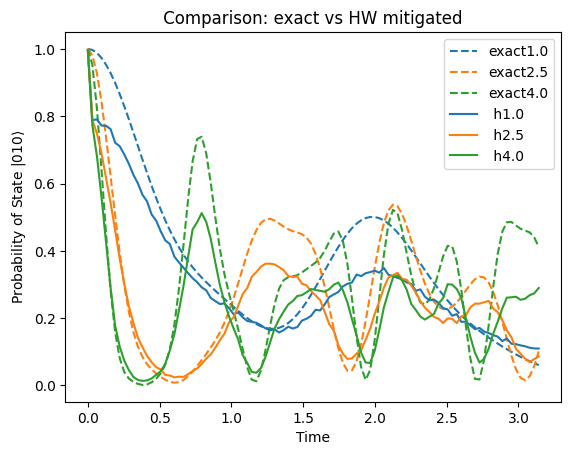

In [71]:
# Now plot the comparison
#plt.plot(ts, probs_010_exact,linestyle="dashed",color="black",label="Exact")
initial_state = Zero^One^Zero

for i in b:
    # Compute probability of remaining in |0010> state over the array of time points
     # ~initial_state gives the bra of the initial state (<0010|)
     # @ is short hand for matrix multiplication
     # U_ising(t) is the unitary time evolution at time t
     # t needs to be wrapped with float(t) to avoid a bug
     # (...).eval() returns the inner product <0010|U_ising(t)|0010>
     #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value,
     # or probability, of remaining in |0010>
    probs_010_exact = [np.abs((~initial_state @ U_ising(num_qubits,J,i,float(t)) @ initial_state).eval())**2 for t in ts]

    # Plot evolution of |010>
    plt.plot(ts, probs_010_exact,linestyle="dashed",label= "exact" + str(i))
    plt.xlabel('Time')
    plt.ylabel(r'Probability of State $|010\rangle$')
    plt.title(r'Evolution of State $|010\rangle$ under $H_{Ising}$ varing the magnetic field')
    plt.legend()
    plt.grid()
# Now plot the comparison
#plt.plot(ts, probs_0010_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_010_trott_mitigated.keys()):
    plt.plot(ts, probs_010_trott_mitigated[n],color="C"+str(i),label=" h" + str(n))
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|010\rangle$')
plt.title(r' Comparison: exact vs HW mitigated ')
plt.legend()
plt.grid()
plt.show()

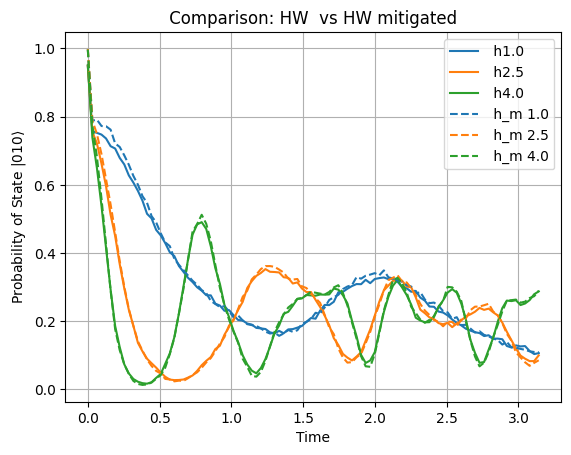

In [72]:
for (i,n) in enumerate(probs_010_trott.keys()):
    plt.plot(ts, probs_010_trott[n],color="C"+str(i),label=" h"+str(n))


for (i,n) in enumerate(probs_010_trott_mitigated.keys()):
    plt.plot(ts, probs_010_trott_mitigated[n],linestyle="dashed", color="C"+str(i),label=" h_m "+str(n))
    
    
plt.xlabel('Time')
plt.ylabel(r'Probability of State $|010\rangle$')
plt.title(r' Comparison: HW  vs HW mitigated ')

plt.legend()
plt.grid()

plt.show()

# Computing Magnetization
$ N_{qubits} = 4 \newline $ 
By adding at the end of the circuit a measurement in the computational basis, we get an estimate of the probabilities $p_0^{(i)},p_1^{(i)}$ of finding each qubit in one of the two eigenstates of $\sigma_z$ (i.e. $\left|0\right\rangle$ and $\left|1\right\rangle$) and therefore with an estimate of the average spin magnetization along the $z$ direction
$$
\left\langle\hat{s}^{(i)}_z(t)\right\rangle = \frac{1}{2}\left\langle\psi (t)\right|\sigma^{(i)}_z(t)\left|\psi(t)\right\rangle = \frac{1}{2}\left(+1 \cdot p_0^{(i)} -1\cdot p_1^{(i)}\right)
$$
where $\left|\psi(t)\right\rangle = U(t)\left|\psi (0)\right\rangle$ is the time evolved state of the two qubits. 

# Classical simulation

In [7]:
J =-1
import numpy as np
c_times = np.linspace(0,0.5*np.pi/abs(J),1000)
q_times = np.linspace(0,0.5*np.pi/abs(J),10)

#Initial state
psi0=Zero^One^Zero^Zero

# Collect value at each time
sz1_t = np.zeros(len(c_times))
sz2_t = np.zeros(len(c_times))
sz3_t = np.zeros(len(c_times))
sz4_t = np.zeros(len(c_times))
sz=np.zeros(len(c_times))

sz1 = I^I^I^Z
sz2 = I^I^Z^I
sz3 = I^Z^I^I
sz4 = Z^I^I^I

for i in range(len(c_times)):
    
    t = c_times[i]
    psi_t = U_ising(num_qubits,J,b,float(t)) @ psi0
    sz1_t[i] = np.real((~psi_t @ sz1 @ psi_t).eval())
    sz2_t[i] = np.real((~psi_t @ sz2 @ psi_t).eval())
    sz3_t[i] = np.real((~psi_t @ sz3 @ psi_t).eval())
    sz4_t[i] = np.real((~psi_t @ sz4 @ psi_t).eval())
    sz[i]=sz1_t[i]+sz2_t[i]+sz3_t[i]+sz4_t[i]

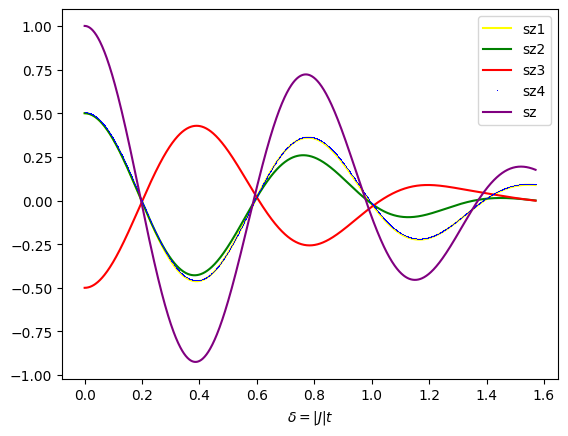

In [8]:
plt.plot(abs(J)*c_times,0.5*sz1_t, 'yellow', label='sz1')
plt.plot(abs(J)*c_times,0.5*sz2_t, 'green', label='sz2')
plt.plot(abs(J)*c_times,0.5*sz3_t, 'r', label='sz3')
plt.plot(abs(J)*c_times,0.5*sz4_t, 'b,', label='sz4')
plt.plot(abs(J)*c_times,0.5*sz, 'purple', label='sz')
plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

# Quantum simulation and error mitigation

The qiskit experiment package also has measurement filters that can be used to mitigate various types of errors, such as **measurements** .
The `measurement calibration` is what we will use to mitigate measurement errors in this section. The process begins by first generating a list of circuits, where each circuit represents each of all the possible states of the qubits specified, then executing the circuits on an ideal simulator, the results of which we will then pass into a measurement filter. The `measurement filter` will then be used to mitigate the measurement errors.

In [9]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
shots=8000

# Error mitigation
qr = QuantumRegister(4)

 ## Genero circuiti di test con diverse caratteristiche:
 ## - cambiano posizioni gates;
 ## - cambiano numero gates, ...
 ## quindi genero una matrice con fit delle performance dei circuiti 
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')


In [10]:
#for circuit in meas_calibs:
#    print('Circuit',circuit.name)
#    print(circuit)
#   print()

In [11]:
# Execute the calibration circuits without noise
# Ideal simulator
#aer_sim     = QasmSimulator(shots=nshots)
aer_sim = Aer.get_backend('aer_simulator')
t_qc_noiseless = transpile(meas_calibs, aer_sim)
qobj_noiseless = assemble(t_qc_noiseless, shots=shots)
cal_results_noiseless = aer_sim.run(qobj_noiseless, shots=shots).result()

# Matrix without noise
meas_fitter_noiseless = CompleteMeasFitter(cal_results_noiseless, state_labels, circlabel='mcal')
array_to_latex(meas_fitter_noiseless.cal_matrix)

## Ottengo una matrice diagonale, cioè ho una corrispondenza diretta 
## tra i valori dei qubit calcolati e quelli ideali

<IPython.core.display.Latex object>

In [16]:
# Execute the calibration circuits with noise
# Noisy simulator
backend = provider.get_backend(HW)
sim_manila = QasmSimulator.from_backend(backend, shots=shots)

t_qc = transpile(meas_calibs, sim_manila)
qobj = assemble(t_qc, shots=shots)
cal_results = sim_manila.run(qobj,  shots=shots).result()

# Matrix with noise
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

## Gli elementi off-diagonal rappresentano le probabilità di errore
## La parte computazionale più difficile è ottenere l'inversa di questa
## matrice per applicarla ai risultati ottenuti dalla simulazione noisy 
## e ricavare i risultati mitigati.

<IPython.core.display.Latex object>

In [17]:
# Get the filter object
meas_filter = meas_fitter.filter

In [20]:
### Ideal quantum simulation of the Ising model using qiskit

# Collect quantum value at every time
sz1_ideal_t = np.zeros(len(q_times))
sz2_ideal_t = np.zeros(len(q_times))
sz3_ideal_t = np.zeros(len(q_times))
sz4_ideal_t = np.zeros(len(q_times))
sz_ideal = np.zeros(len(q_times))



num_qubits=4

##  Run the quantum algorithm

n=15

for k, sim_t in enumerate(q_times):
    
    trott_qr = QuantumRegister(4)
    trott_qc = QuantumCircuit(trott_qr)
    trott_qc.x(2)
    
    #Trotterization in order to use the previous circuit 
    trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
    trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
    
    # Measure
    trott_qc.measure_all()
    
    # Run the quantum algorithm with noise 
    job = execute(trott_qc, backend = aer_sim, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # Post processing of outcomes to get sz expectation values
    sz1q = 0
    sz2q = 0
    sz3q = 0
    sz4q = 0
    
    for key,value in counts.items():
        if key == '0000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q += value
        elif key == '0010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '0001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '0011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '1110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q -= value
        elif key == '0111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '1011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1101':
            sz1q -= value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '1111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q -= value
      
    
    sz1_ideal_t[k] = sz1q/shots
    sz2_ideal_t[k] = sz2q/shots
    sz3_ideal_t[k] = sz3q/shots
    sz4_ideal_t[k] = sz4q/shots
    sz_ideal[k]= sz1_ideal_t[k]+sz2_ideal_t[k]+sz3_ideal_t[k]+sz4_ideal_t[k]

# Comparison between classical and ideal results

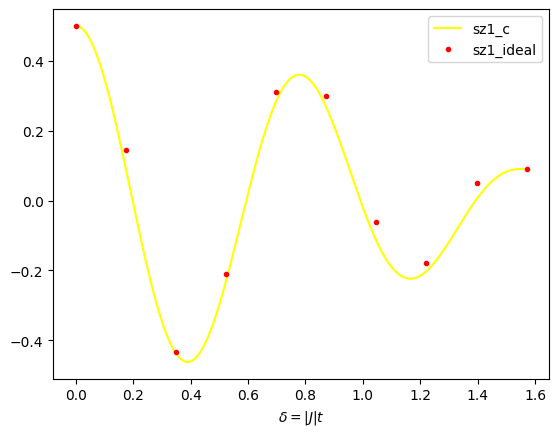

In [21]:
plt.plot(abs(J)*c_times,0.5*sz1_t, 'yellow', label='sz1_c')
plt.plot(abs(J)*q_times,0.5*sz1_ideal_t,'r.', label='sz1_ideal')


plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

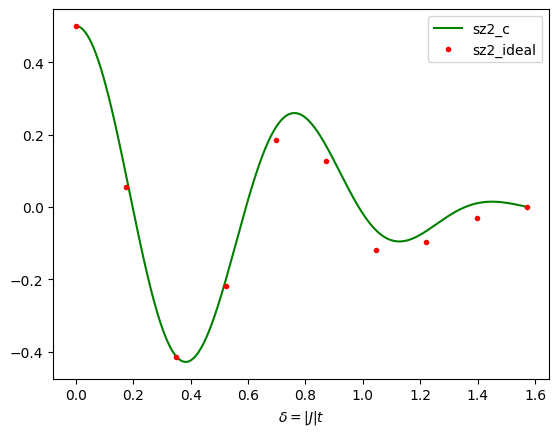

In [22]:
plt.plot(abs(J)*c_times,0.5*sz2_t, 'green', label='sz2_c')
plt.plot(abs(J)*q_times,0.5*sz2_ideal_t,'r.', label='sz2_ideal')


plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

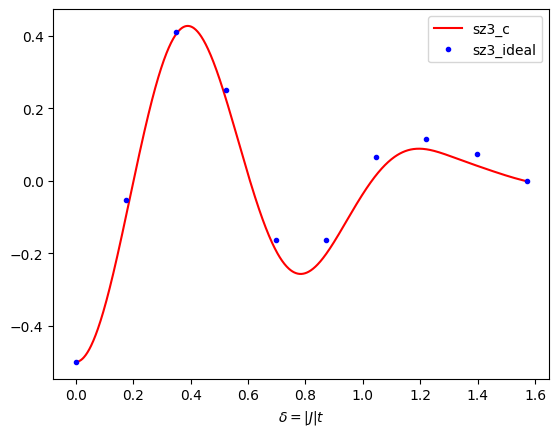

In [23]:
plt.plot(abs(J)*c_times,0.5*sz3_t, 'r', label='sz3_c')
plt.plot(abs(J)*q_times,0.5*sz3_ideal_t,'b.', label='sz3_ideal')


plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

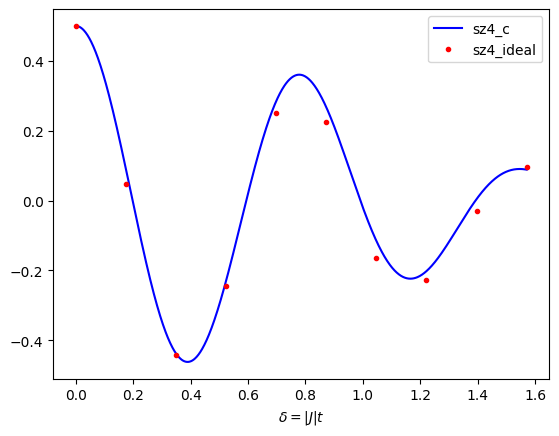

In [24]:
plt.plot(abs(J)*c_times,0.5*sz4_t, 'b', label='sz4_c')
plt.plot(abs(J)*q_times,0.5*sz4_ideal_t,'r.', label='sz4_ideal')


plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

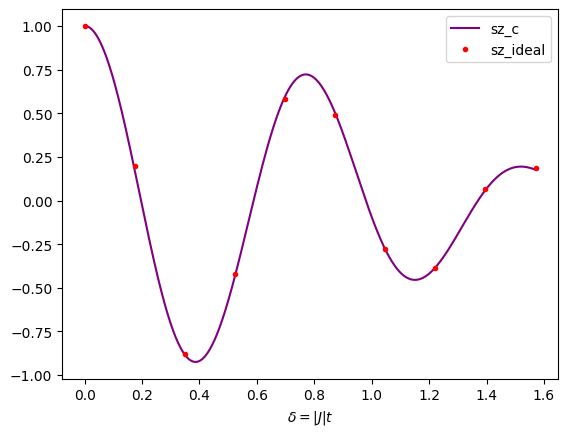

In [25]:
plt.plot(abs(J)*c_times,0.5*sz, 'purple', label='sz_c')
plt.plot(abs(J)*q_times,0.5*sz_ideal,'r.', label='sz_ideal')


plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

Le differenze tra i valori è dovuta al numero finito di Trotter steps.

In [26]:
### Digital quantum simulation of the Ising model using qiskit

# Collect quantum value at every time
sz1q_t = np.zeros(len(q_times))
sz2q_t = np.zeros(len(q_times))
sz3q_t = np.zeros(len(q_times))
sz4q_t = np.zeros(len(q_times))
szq = np.zeros(len(q_times))

# Collect quantum mitigated value at every time
sz1qm_t = np.zeros(len(q_times))
sz2qm_t = np.zeros(len(q_times))
sz3qm_t = np.zeros(len(q_times))
sz4qm_t = np.zeros(len(q_times))
szqm = np.zeros(len(q_times))

num_qubits=4

##  Run the quantum algorithm

n=15

for k, sim_t in enumerate(q_times):
    
    trott_qr = QuantumRegister(4)
    trott_qc = QuantumCircuit(trott_qr)
    trott_qc.x(2)
    
    #Trotterization in order to use the previous circuit 
    trott_steps = Ising_Trotter(num_qubits=4,J=-1,b=4,trotter_steps=n,t=sim_t)
    trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2], trott_qr[3]])
    
    # Measure
    trott_qc.measure_all()
    
    # Run the quantum algorithm with noise 
    job = execute(trott_qc, sim_manila)
    result = job.result()
    counts = result.get_counts()
    
    # Post processing of outcomes to get sz expectation values
    sz1q = 0
    sz2q = 0
    sz3q = 0
    sz4q = 0
    
    for key,value in counts.items():
        if key == '0000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1000':
            sz1q += value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q += value
        elif key == '0010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '0001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q += value
        elif key == '1100':
            sz1q += value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1010':
            sz1q += value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '0110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '0011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q += value
        elif key == '1110':
            sz1q += value
            sz2q -= value
            sz3q -= value
            sz4q -= value
        elif key == '0111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q += value
        elif key == '1011':
            sz1q -= value
            sz2q -= value
            sz3q += value
            sz4q -= value
        elif key == '1101':
            sz1q -= value
            sz2q += value
            sz3q -= value
            sz4q -= value
        elif key == '1001':
            sz1q -= value
            sz2q += value
            sz3q += value
            sz4q -= value
        elif key == '1111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
            sz4q -= value
      
    
    sz1q_t[k] = sz1q/shots
    sz2q_t[k] = sz2q/shots
    sz3q_t[k] = sz3q/shots
    sz4q_t[k] = sz4q/shots
    szq[k]= sz1q_t[k]+sz2q_t[k]+sz3q_t[k]+sz4q_t[k]
    
    
    
    ##Error Mitigation

    mitigated_results = meas_filter.apply(result)
    mitigated_counts = mitigated_results.get_counts()
    
    sz1qm = 0
    sz2qm = 0
    sz3qm = 0
    sz4qm = 0

    for key,value in mitigated_counts.items():
        if key == '0000':
            sz1qm += value
            sz2qm += value
            sz3qm += value
            sz4qm += value
        elif key == '1000':
            sz1qm += value
            sz2qm += value
            sz3qm += value
            sz4qm -= value
        elif key == '0100':
            sz1qm += value
            sz2qm += value
            sz3qm -= value
            sz4qm += value
        elif key == '0010':
            sz1qm += value
            sz2qm -= value
            sz3qm += value
            sz4qm += value
        elif key == '0001':
            sz1qm -= value
            sz2qm += value
            sz3qm += value
            sz4qm += value
        elif key == '1100':
            sz1qm += value
            sz2qm += value
            sz3qm -= value
            sz4qm -= value
        elif key == '1010':
            sz1qm += value
            sz2qm -= value
            sz3qm += value
            sz4qm -= value
        elif key == '1001':
            sz1qm -= value
            sz2qm += value
            sz3qm += value
            sz4qm -= value
        elif key == '0110':
            sz1qm += value
            sz2qm -= value
            sz3qm -= value
            sz4qm += value
        elif key == '0011':
            sz1qm -= value
            sz2qm -= value
            sz3qm += value
            sz4qm += value
        elif key == '1110':
            sz1qm += value
            sz2qm -= value
            sz3qm -= value
            sz4qm -= value
        elif key == '0111':
            sz1qm -= value
            sz2qm -= value
            sz3qm -= value
            sz4qm += value
        elif key == '1011':
            sz1qm -= value
            sz2qm -= value
            sz3qm += value
            sz4qm -= value
        elif key == '1101':
            sz1qm -= value
            sz2qm += value
            sz3qm -= value
            sz4qm -= value
        elif key == '1001':
            sz1qm -= value
            sz2qm += value
            sz3qm += value
            sz4qm -= value
        elif key == '1111':
            sz1qm -= value
            sz2qm -= value
            sz3qm -= value
            sz4qm -= value

    sz1qm_t[k] = sz1qm/shots
    sz2qm_t[k] = sz2qm/shots
    sz3qm_t[k] = sz3qm/shots
    sz4qm_t[k] = sz4qm/shots
    szqm[k]= sz1qm_t[k]+sz2qm_t[k]+sz3qm_t[k]+sz4qm_t[k]


# Comparison between classical, noisy and mitigated results

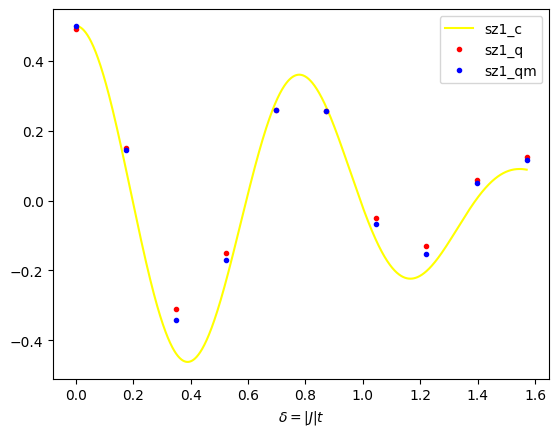

In [27]:
plt.plot(abs(J)*c_times,0.5*sz1_t, 'yellow', label='sz1_c')
plt.plot(abs(J)*q_times,0.5*sz1q_t,'r.', label='sz1_q')
plt.plot(abs(J)*q_times,0.5*sz1qm_t,'b.', label='sz1_qm')

plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

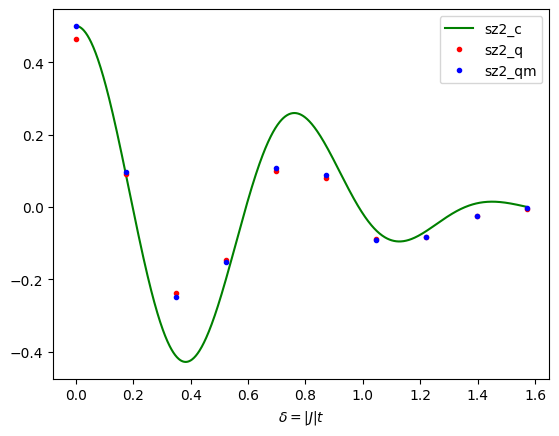

In [28]:
plt.plot(abs(J)*c_times,0.5*sz2_t, 'green', label='sz2_c')
plt.plot(abs(J)*q_times,0.5*sz2q_t,'r.', label='sz2_q')
plt.plot(abs(J)*q_times,0.5*sz2qm_t,'b.', label='sz2_qm')

plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

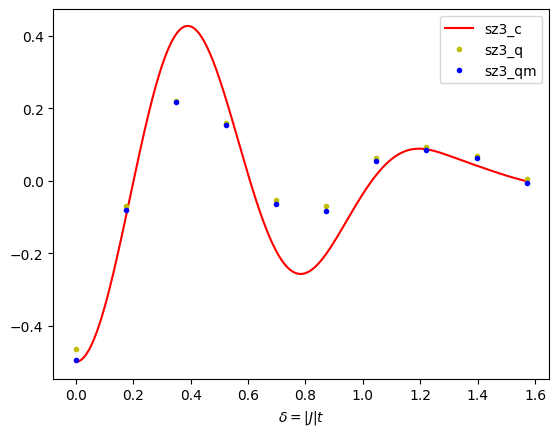

In [29]:
plt.plot(abs(J)*c_times,0.5*sz3_t, 'r', label='sz3_c')
plt.plot(abs(J)*q_times,0.5*sz3q_t,'y.', label='sz3_q')
plt.plot(abs(J)*q_times,0.5*sz3qm_t,'b.', label='sz3_qm')

plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

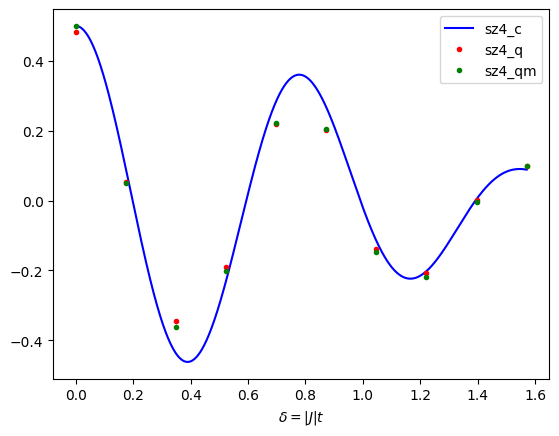

In [30]:
plt.plot(abs(J)*c_times,0.5*sz4_t, 'b', label='sz4_c')
plt.plot(abs(J)*q_times,0.5*sz4q_t,'r.', label='sz4_q')
plt.plot(abs(J)*q_times,0.5*sz4qm_t,'g.', label='sz4_qm')

plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()

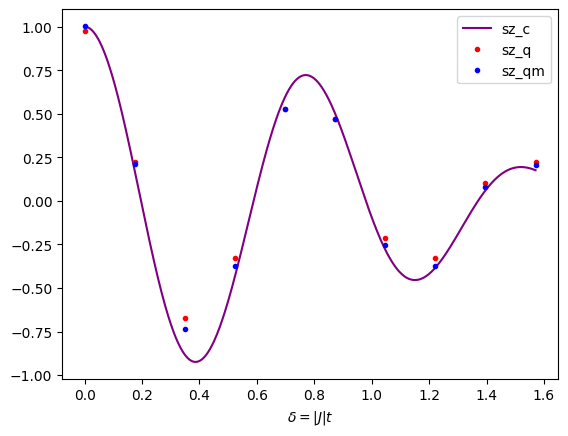

In [31]:
plt.plot(abs(J)*c_times,0.5*sz, 'purple', label='sz_c')
plt.plot(abs(J)*q_times,0.5*szq,'r.', label='sz_q')
plt.plot(abs(J)*q_times,0.5*szqm,'b.', label='sz_qm')

plt.legend()
plt.xlabel(r'$\delta = |J|t$')
plt.show()